In [ ]:
from torchmetrics.multimodal import CLIPScore

metric = CLIPScore(model_name_or_path='M-CLIP/XLM-Roberta-Large-Vit-B-16Plus')

In [1]:
import torchvision.transforms as transforms
from PIL import Image
import cv2


def read_image(path):
    img = Image.open(path).convert('RGB')

    resize = transforms.Resize([224, 224])
    img = resize(img)
    to_tensor = transforms.ToTensor()

    tensor = to_tensor(img)
    return tensor


def show_image(path):
    image = cv2.imread(path)

    size = 400, 400
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image.thumbnail(size, Image.Resampling.LANCZOS)

    return image

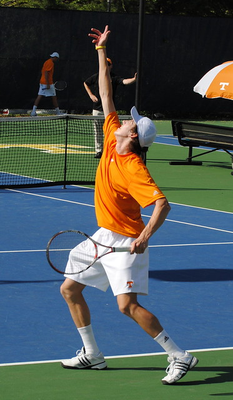

In [38]:
name = "clipscore_test/1.jpg"
text = "Хлеб розетка вселенная"
show_image(name)

In [39]:
cocoScore = metric(read_image(name), text)
cocoScore.detach()

tensor(14.4100)

In [ ]:
from multilingual_clip import pt_multilingual_clip
import transformers
import torch
import open_clip
import requests
from PIL import Image

model_name = 'M-CLIP/XLM-Roberta-Large-Vit-B-16Plus'

model_caption = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_img, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model_img.to(device)

In [47]:
def compare_embeddings(logit_scale, img_embs, txt_embs):
    image_features = img_embs / img_embs.norm(dim=-1, keepdim=True)
    text_features = txt_embs / txt_embs.norm(dim=-1, keepdim=True)

    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logit_scale * text_features @ image_features.t()

    return logits_per_image, logits_per_text

In [77]:
logit_scale = model_img.logit_scale.exp().float()

In [81]:
def give_logits(text, name):
    text_features = model_caption.forward(text, tokenizer).detach().cpu()
    with Image.open(name) as curimg:
        images = preprocess(curimg).unsqueeze(0)
    image_features = model_img.encode_image(images.to(device)).detach().float()
    img_logits, text_logits = compare_embeddings(logit_scale, image_features, text_features.to(device))
    return img_logits

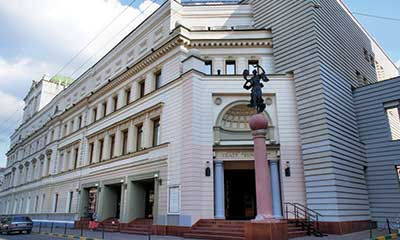

In [82]:
name1 = "clipscore_test/2.jpg"
show_image(name1)

In [102]:
text1 = "Театр в городе Нижний Новгород"
give_logits(text1, name1)

tensor([[36.0359]], device='cuda:0', grad_fn=<MmBackward0>)

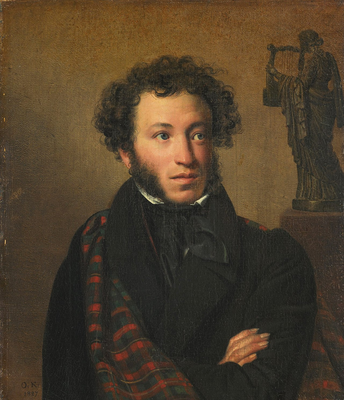

In [84]:
name2 = "clipscore_test/3.jpg"
show_image(name2)

In [112]:
text2 = "Александр Сергеевич Пушкин"
give_logits(text2, name2)

tensor([[27.1463]], device='cuda:0', grad_fn=<MmBackward0>)

In [ ]:
# Смотрим переводчик

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", use_auth_token=True, src_lang="eng_Latn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M", use_auth_token=True)

article = "Hello world!"
inputs = tokenizer(article, return_tensors="pt")

translated_tokens = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["rus_Cyrl"], max_length=30)
tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]